# 05_OverviewMaps

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator


import matplotlib.dates as mdates


from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_nsidc.icedrift as icedrift
import data_unibremen.SIC as unisic


sys.path.append('../')
import functions as fn

plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)

In [2]:
from pyproj import Geod
g = Geod(ellps='WGS84')

### Import constants

In [3]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [4]:

# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))



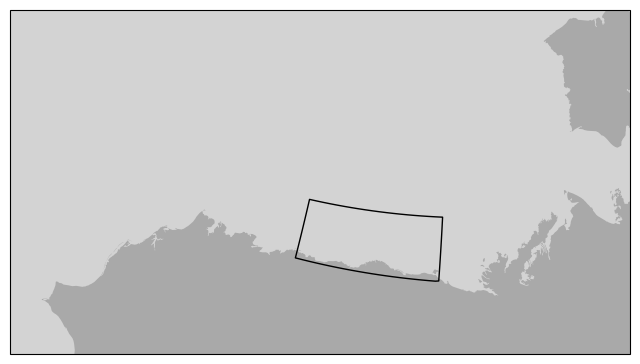

In [5]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# for key in ['era', 'ppd']:
#     ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
#                zorder=100, s = 10, transform=ccrs.PlateCarree())


In [6]:
dsb = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
# dsb = dsb.sel(xx=slice(-2346875, -446875), yy=slice(-1546875, 2846875))


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def create_map_box(proj, lon_range=(-165, -120), lat_range = (68, 78)):
    
    # Bounding box in degrees
    lon_min, lon_max = lon_range[0], lon_range[1]
    lat_min, lat_max = lat_range[0], lat_range[1]
    
    # Sample points along each edge
    npts = 100
    # Sample border points:
    # Bottom edge: latitude fixed at lat_min, lon varies left to right
    bottom = [(lon, lat_min) for lon in np.linspace(lon_min, lon_max, npts)]
    # Right edge: longitude fixed at lon_max, lat varies bottom to top
    right = [(lon_max, lat) for lat in np.linspace(lat_min, lat_max, npts)]
    # Top edge: latitude fixed at lat_max, lon varies right to left
    top = [(lon, lat_max) for lon in np.linspace(lon_max, lon_min, npts)]
    # Left edge: longitude fixed at lon_min, lat varies top to bottom
    left = [(lon_min, lat) for lat in np.linspace(lat_max, lat_min, npts)]
    
    # Combine in order to make a closed polygon
    all_coords = bottom + right + top + left

    # Transform each point to map projection coordinates
    projected_coords = [proj.transform_point(lon, lat, ccrs.PlateCarree()) for lon, lat in all_coords]

    # Create a closed path
    clip_path = mpath.Path(projected_coords)
    
    return clip_path



In [9]:
moors = {}
for M in ['M1', 'M2', 'M3', 'M4']:
    moors[M] = {}
    path = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
    with xr.open_dataset(path+f'{M}/{M}_hourly_ocean_currents_2016_2017.nc') as ds:
        print(M, ds.attrs)
        
        moors[M] = ds.attrs
        
df2 = pd.read_csv('../data/start_points_v7.6.nc')

M1 {'lat': 69.7706, 'lon': -139.2548}
M2 {'lat': 69.908, 'lon': -138.9988}
M3 {'lat': 70.0485, 'lon': -138.7949}
M4 {'lat': 70.2517, 'lon': -138.7938}


In [10]:
dsb2 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/gebco_2023_n88.8988_s61.7506_w170.0_e250.0.nc')
dsb2 = dsb2.sel(lat=slice(68.5,73.2),lon=slice(200,235))
# dsb2

In [12]:
RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

In [13]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Define multiple colors for subtle gradients
colors = [
    (0.2, 0.3, 0.5),    # darkest blue
    (0.3, 0.45, 0.65),  # medium blue
    (0.5, 0.65, 0.8),   # lighter blue
    (0.75, 0.83, 0.9),  # pale blue-gray
    (0.95, 0.97, 0.98)  # very pale, almost white (sea level)
]

cmap = LinearSegmentedColormap.from_list("gray_to_deep_blue", colors, N=256)
# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.deep_r, 20, which='min', N=None)

norm = TwoSlopeNorm(vmin=-3000, vcenter=-400, vmax=0)


In [15]:
# # Define projections
# proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# # map bound
# lon_range = (-150, -135)
# lat_range = (69, 72)


# FS = 9

# # grab box border
# clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# # Plotting
# fig, ax = plt.subplots(figsize=(5,3), subplot_kw={'projection': proj})

# # ax.set_boundary(clip_path, transform=proj)
# ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
# geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
# ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
#            colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
# ax.add_geometries ([reg_poly], ls='solid', lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], transform=dsic['proj'], 
#               cmap=cmocean.cm.ice)

# ax.scatter(xx_poly, yy_poly, s=1, c='darkgray', transform=dsic['proj'], )

In [16]:
colors = [
    (-3000, (0.35, 0.45, 0.65)),  # lighter deep blue
    (-2000, (0.55, 0.70, 0.85)),  # light blue
    (-1000,  (0.75, 0.85, 0.92)),  # very light blue
    (-400,   (0.88, 0.92, 0.95)),  # pale blue-gray
    (-100,     (0.98, 0.98, 0.99))   # near-white at sea level
]
# Normalize depth values to 0–1
depths, rgb = zip(*colors)
depths = np.array(depths)
rgb = np.array(rgb)
norm_depths = (depths - depths.min()) / (depths.max() - depths.min())

# Create colormap with nonuniform spacing
cmap = LinearSegmentedColormap.from_list("stretched_near_surface", list(zip(norm_depths, rgb)))

In [17]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.patches import Circle

from matplotlib.ticker import FixedLocator

### Grab poly points

In [18]:

DATE = datetime(2024,1,14)



RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

dss = xr.open_dataset('../data/polynya_size/daily_polynya_2024_sic10_v7.6_radius25km.nc')
dss = dss.sel(time=DATE)

xx_poly = np.array([float(XX) for XX in dss.poly_interior_xx.values.item().split('_')[1:]])
yy_poly = np.array([float(YY) for YY in dss.poly_interior_yy.values.item().split('_')[1:]])

xx_edge = np.array([float(XX) for XX in dss.ice_edge_xx.values.item().split('_')[1:]])
yy_edge = np.array([float(YY) for YY in dss.ice_edge_yy.values.item().split('_')[1:]])


poly_points = np.full(dsic['xx'].shape, 0.0)

for xx, yy  in zip(xx_poly, yy_poly):
    
    dist = (dsic['xx'] - xx)**2 + (dsic['yy'] - yy)**2
    
    poly_points[np.where(dist == 0)] =1.0
    
for xx, yy  in zip(xx_edge, yy_edge):
    
    dist = (dsic['xx'] - xx)**2 + (dsic['yy'] - yy)**2
    
    poly_points[np.where(dist == 0)] =0.5

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)


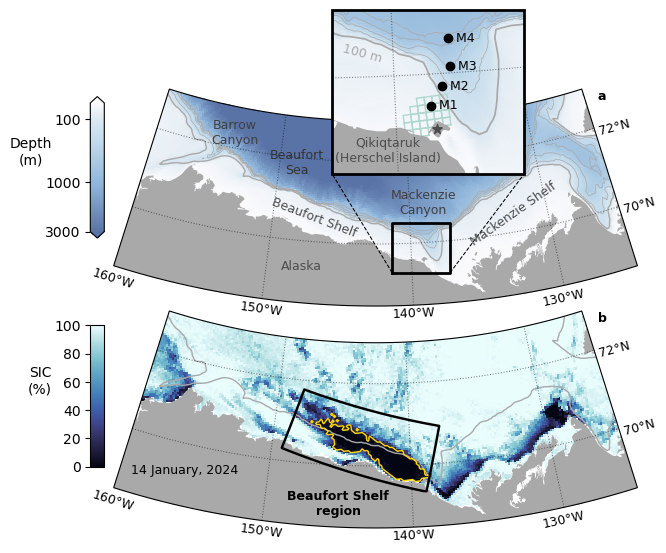

In [25]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-160, -125)
lat_range = (68.5, 73)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, axs = plt.subplots(2,1,figsize=(7,7), subplot_kw={'projection': proj})

# fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': proj})

for ax in axs:
    
    ax.set_boundary(clip_path, transform=proj)
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
    geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
               colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
    gl.xlocator = FixedLocator([-160, -150, -140, -130])
    gl.ylocator = FixedLocator([70,72,])
    gl.bottom_labels = False
    gl.right_labels = False

for ax in [axs[0], axs[1]]:
    for lat in [70,72,]:
        ax.text(-124.75, lat, f"{lat}°N",
                transform=ccrs.PlateCarree(),
                ha='left', va='center', clip_on=False, rotation=15)
    for lon in [-160, -150, -140, -130]:
        rot = lon-(-142.5)
        ax.text(lon, 68.4755, f"{-lon}°W",
                transform=ccrs.PlateCarree(),
                ha='center', va='top',rotation=rot, clip_on=False, size=plt.rcParams['font.size'])
            

# --------------- bathymetry -----------------------------
ax = axs[0]
sp = 20
ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['darkgray'], transform=ccrs.PlateCarree())


mesh = ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
           cmap=cmap, norm=norm, transform=dsic['proj'])

COLOR = [0.3,0.3,0.3]

ax.text(-149,69.25, 'Alaska', rotation=0,c=COLOR, transform=ccrs.PlateCarree())
# ax.text(-148,72.45, 'Canada Basin', rotation=0,c=COLOR, transform=ccrs.PlateCarree())
ax.text(-148.6,71.6, 'Beaufort\nSea', rotation=0,c=[0.2,0.2,0.2], ha='center', transform=ccrs.PlateCarree())

ax.text(-150,70., 'Beaufort Shelf', rotation=-21,c=COLOR, transform=ccrs.PlateCarree())
ax.text(-136.,69.85, 'Mackenzie Shelf', rotation=35, c=COLOR,transform=ccrs.PlateCarree())
ax.text(-153.75, 72.1, 'Barrow\nCanyon', rotation=0, ha='center', c=[0.25]*3,transform=ccrs.PlateCarree())
ax.text(-139, 70.7, 'Mackenzie\nCanyon', rotation=0,ha='center', c=[0.25]*3,transform=ccrs.PlateCarree())

# # ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())
# # ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())

plotter.add_colorbar(fig, ax, [mesh], cb_placement='left', 
                     cb_orientation='auto', cb_width=0.02, 
                     cb_length_fraction=[0.15, 0.8], 
                     cb_pad=0, cb_ticks=[-3000,-1000,-100], cb_ticklabels=['3000', '1000', '100'], 
                     cb_extend='both', cb_label='Depth\n(m)', 
                     labelpad=10, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])


# --------------- SIC -----------------------------

ax = axs[1]

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'
# dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
#                               main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
#                                   crop=crop, coordinates=True, area=False, include_units=False, 
#                                   quiet=True)
# mesh = ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], cmap=cmocean.cm.ice, transform=dsic['proj'])



RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

mesh = ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], cmap=cmocean.cm.ice, transform=dsic['proj'])

plotter.add_colorbar(fig, ax, [mesh], cb_placement='left', 
                     cb_orientation='auto', cb_width=0.02, 
                     cb_length_fraction=[0.15+0.3, 0.8+0.3], 
                     cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', 
                     cb_extend='neither', cb_label='SIC\n(%)', 
                     labelpad=10, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])


# ax.contour(dsic['xx'], dsic['yy'], dsic['sic'], levels=[10], colors=['gold'], linewdiths=[0.5], transform=dsic['proj'])

ax.contour(dsic['xx'], dsic['yy'], poly_points, levels=[0.75], colors=['gold'],
           linewidths=[1], linestyles='solid', transform=dsic['proj'])


ax.add_geometries ([reg_poly], lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
ax.text(-145,68.8, 'Beaufort Shelf\nregion',
        ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())
ax.text(0.05,0.25, '14 January, 2024',
        ha='left', weight='normal', rotation=0,c='k', transform=ax.transAxes)


# --------------- inset map -----------------------------
for ax, lab in zip(axs, ['a', 'b']):
    ax.text(0.91,0.95,lab, weight='bold', transform=ax.transAxes)

    
inset_ax = fig.add_axes([0.45, 0.67, 0.275, 0.27], projection=proj)
lon_range = (-141.3, -137.4)
lat_range = (69.3, 70.425)

ax = inset_ax

ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

sp = 5
# norm=norm,
mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                      cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

mesh =  ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['darkgray'], transform=ccrs.PlateCarree())

inset_ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.25],linestyles=['solid'], transform=dsic['proj'])

gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
gl.xlocator = FixedLocator([-160, -150, -140, -130])
gl.ylocator = FixedLocator([70,72,])
gl.bottom_labels = False
gl.right_labels = False


COLOR = [0.3,0.3,0.3]

for m in moors.keys():
    ax.scatter(moors[m]['lon'], moors[m]['lat'], transform=ccrs.PlateCarree(), c='k', zorder=100)
    ax.text(moors[m]['lon'], moors[m]['lat'], f'  {m}', weight='normal', va='center', transform=ccrs.PlateCarree(), c='k', zorder=100)

ax.text(0.29, 0.075, 'Qikiqtaruk\n(Herschel Island)', weight='normal', rotation=0, ha='center', c=COLOR,transform=ax.transAxes)
ax.scatter(-139.15, 69.595, marker='*', s=50, c=COLOR, zorder=100, transform=ccrs.PlateCarree())
ax.text(0.05, 0.68, '100 m', c='darkgray', rotation = -15, transform=ax.transAxes)

df2 = pd.read_csv('../data/start_points_v7.6.nc')

for xxx, yyy in zip(df2.x_pts, df2.y_pts):

    plt.plot([xxx-6250/2,xxx+6250/2,xxx+6250/2,xxx-6250/2,xxx-6250/2,],
             [yyy-6250/2,yyy-6250/2,yyy+6250/2,yyy+6250/2, yyy-6250/2,], 
             c=[175/255, 215/255, 205/255], lw=1,  transform=dsic['proj'], zorder=1)

for spine in inset_ax.spines.values():
    spine.set_linewidth(2)  # Change this value to make it thicker


# --------------- add bounding box -----------------------------
box = inset_ax.get_extent()
L = box[0]
R = box[1]
B = box[2]
T = box[3]
axs[0].plot([L,R,R,L,L], [B,B,T,T,B], c='k', lw=2)


axs[0].plot([L, L-170000], [B, B+280000], ls='dashed', lw=0.75, c='k')
axs[0].plot([R, R+210000], [B, B+280000], ls='dashed', lw=0.75, c='k')


# --------------- save -----------------------------


plt.subplots_adjust(hspace=-0.3)



SAVE(fig, '../figures/overview/Fig01.png')


In [135]:
# Use a polar stereographic projection
# proj = ccrs.NorthPolarStereo(central)

# Create figure and axis
# fig = plt.figure(figsize=(2,2))
# ax = plt.axes(projection=proj)

def show_polar():
    
    ax = fig.add_axes([0.25, 0.775, 0.2, 0.2], projection=proj)

    # Set extent: from 60°N to 90°N
    ax.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())

    # Add basic map features
    # ax.add_feature(cfeature.LAND, facecolor='lightgray')
    # ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    # ax.coastlines()
    ax.gridlines(draw_labels=False, linewidth=0.5, color='k', alpha=0.5, linestyle='dotted', zorder=1000)
    gl.xlocator = FixedLocator([-160, -150, -140, -130])
    gl.ylocator = FixedLocator([70,72,])

    # --- Crop to a circle around the pole at 60°N ---
    # Create a circular path around the pole (radius defined by 60°N)
    theta = np.linspace(0, 2 * np.pi, 100)
    center = [0, 0]
    radius = proj.transform_point(0, 55, ccrs.PlateCarree())[1]  # Y value at 60°N

    circle_path = mpath.Path(np.column_stack([
        radius * np.cos(theta),
        radius * np.sin(theta)
    ]))

    # Clip the map to this circular path
    ax.set_boundary(circle_path, transform=proj)

#     sp = 10
#     mesh = ax.pcolormesh(dsb['xx'][::sp,], dsb['yy'][::sp,], dsb['avg'][::sp,::sp],
#                cmap=cmap, norm=norm, transform=dsic['proj'])

#     geomap.land(ax, scale='50m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)


    line_kw = {'lw':1, 'c':'k'}
    ax.plot(np.linspace(-160,-125, 20), np.full(20,73), transform=ccrs.PlateCarree(), **line_kw)
    ax.plot(np.full(20,-125),np.linspace(68.5,73, 20), transform=ccrs.PlateCarree(), **line_kw)
    ax.plot(np.full(20,-160),np.linspace(68.5,73, 20), transform=ccrs.PlateCarree(), **line_kw)
    ax.plot(np.linspace(-160,-125, 20), np.full(20,68.5), transform=ccrs.PlateCarree(), **line_kw)
    
    return ax

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)


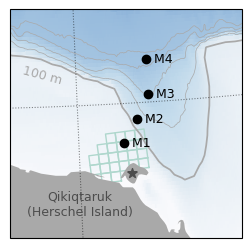

In [42]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-141.1, -137.4)
lat_range = (69.25, 70.5)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.25],linestyles=['solid'], transform=dsic['proj'])

FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': proj})

# ax.set_boundary(clip_path, transform=proj)
# ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.25],linestyles=['solid'], transform=dsic['proj'])
# ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 5
# norm=norm,
mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                      cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

mesh =  ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['darkgray'], transform=ccrs.PlateCarree())


gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
gl.xlocator = FixedLocator([-160, -150, -140, -130])
gl.ylocator = FixedLocator([70,72,])
gl.bottom_labels = False
gl.right_labels = False
# for lat in [70,72,]:
#     ax.text(-124.5, lat, f"{lat}°N",
#             transform=ccrs.PlateCarree(),
#             ha='left', va='center', clip_on=False, rotation=15)
# for lon in [-160, -150, -140, -130]:
#     ax.text(lon, 68.35, f"{-lon}°W",
#             transform=ccrs.PlateCarree(),
#             ha='center', va='top', clip_on=False, rotation=0)

COLOR = [0.3,0.3,0.3]

for m in moors.keys():
    ax.scatter(moors[m]['lon'], moors[m]['lat'], transform=ccrs.PlateCarree(), c='k', zorder=100)
    ax.text(moors[m]['lon'], moors[m]['lat'], f'  {m}', weight='normal', va='center', transform=ccrs.PlateCarree(), c='k', zorder=100)
    



ax.text(0.3, 0.1, 'Qikiqtaruk\n(Herschel Island)', weight='normal', rotation=0, ha='center', c=COLOR,transform=ax.transAxes)
ax.scatter(-139.15, 69.595, marker='*', s=50, c=COLOR, zorder=100, transform=ccrs.PlateCarree())
ax.text(0.05, 0.675, '100 m', c='darkgray', rotation = -15, transform=ax.transAxes)


df2 = pd.read_csv('../data/start_points_v7.6.nc')

for xxx, yyy in zip(df2.x_pts, df2.y_pts):

    plt.plot([xxx-6250/2,xxx+6250/2,xxx+6250/2,xxx-6250/2,xxx-6250/2,],
             [yyy-6250/2,yyy-6250/2,yyy+6250/2,yyy+6250/2, yyy-6250/2,], 
             c=[175/255, 215/255, 205/255], lw=1,  transform=dsic['proj'], zorder=1)


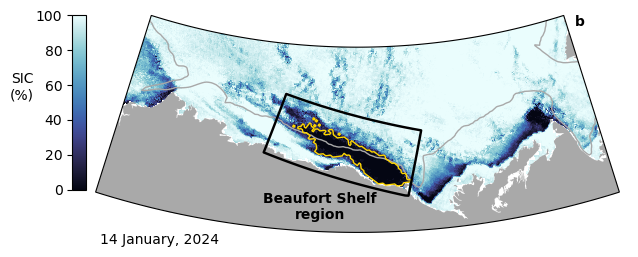

In [368]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-160, -125)
lat_range = (68.5, 73)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': proj})

ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
ax.add_geometries ([reg_poly], lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 20
# norm=norm,
# mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
#            cmap=cmap, norm=norm, transform=dsic['proj'])


# # Optional: Gridlines



# gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
#                   linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
# gl.xlocator = FixedLocator([-160, -150, -140, -130])
# gl.ylocator = FixedLocator([70,72,])
# gl.bottom_labels = False
# gl.right_labels = False
# for lat in [70,72,]:
#     ax.text(-124.5, lat, f"{lat}°N",
#             transform=ccrs.PlateCarree(),
#             ha='left', va='center', clip_on=False, rotation=15)
# for lon in [-160, -150, -140, -130]:
#     ax.text(lon, 68.35, f"{-lon}°W",
#             transform=ccrs.PlateCarree(),
#             ha='center', va='top', clip_on=False, rotation=0)

# COLOR = [0.2,0.2,0.2]


# ax.text(-150,70., 'Beaufort Shelf', rotation=-21,c=COLOR, transform=ccrs.PlateCarree())
# ax.text(-137,69.75, 'Mackenzie Shelf', rotation=35, c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-153, 72.1, 'Barrow\nCanyon', rotation=0, ha='center', c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-139, 70.5, 'Mackenzie\nCanyon', rotation=0,ha='center', c=COLOR,transform=ccrs.PlateCarree())

RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
mesh = ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], cmap=cmocean.cm.ice, transform=dsic['proj'])



RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
# ax.contour(dsic['xx'], dsic['yy'], dsic['sic'], levels=[10], colors=['gold'], linewdiths=[0.5], transform=dsic['proj'])

ax.contour(dsic['xx'], dsic['yy'], poly_points, levels=[0.75], colors=['gold'],
           linewidths=[1], linestyles='solid', transform=dsic['proj'])

# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())
# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())

plotter.add_colorbar(fig, ax, [mesh], cb_placement='left', 
                     cb_orientation='auto', cb_width=0.02, 
                     cb_length_fraction=[0.2, 1], 
                     cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', 
                     cb_extend='neither', cb_label='SIC\n(%)', 
                     labelpad=10, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

ax.text(0.9,0.95,'b', weight='bold', transform=ax.transAxes)

ax.text(-145,68.8, 'Beaufort Shelf\nregion',
        ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())

# ax.text(-140,71.5, 'Beaufort Shelf\nregion',
#         ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())

# ax.text(0.45,0.075, 'Mackenzie\nCoastal\nPolynya',
#         ha='center', weight='normal', rotation=0,c='k', transform=ax.transAxes)


ax.text(0.025,-0.05, '14 January, 2024',
        ha='left', weight='normal', rotation=0,c='k', transform=ax.transAxes)

fig.savefig('../figures/overview/bath_sic.png', dpi=400, bbox_inches='tight', pad_inches=0)

### By date

NameError: name 'dsic' is not defined

NameError: name 'poly_points' is not defined

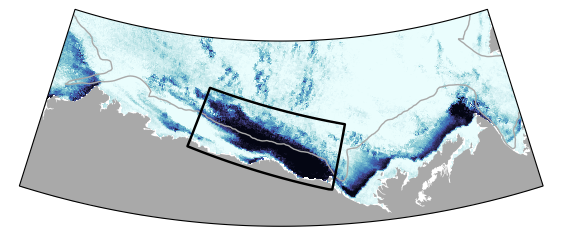

In [18]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-160, -125)
lat_range = (68.5, 73)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': proj})

ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
ax.add_geometries ([reg_poly], lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 20
# norm=norm,
# mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
#            cmap=cmap, norm=norm, transform=dsic['proj'])


# # Optional: Gridlines



# gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
#                   linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
# gl.xlocator = FixedLocator([-160, -150, -140, -130])
# gl.ylocator = FixedLocator([70,72,])
# gl.bottom_labels = False
# gl.right_labels = False
# for lat in [70,72,]:
#     ax.text(-124.5, lat, f"{lat}°N",
#             transform=ccrs.PlateCarree(),
#             ha='left', va='center', clip_on=False, rotation=15)
# for lon in [-160, -150, -140, -130]:
#     ax.text(lon, 68.35, f"{-lon}°W",
#             transform=ccrs.PlateCarree(),
#             ha='center', va='top', clip_on=False, rotation=0)

# COLOR = [0.2,0.2,0.2]


# ax.text(-150,70., 'Beaufort Shelf', rotation=-21,c=COLOR, transform=ccrs.PlateCarree())
# ax.text(-137,69.75, 'Mackenzie Shelf', rotation=35, c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-153, 72.1, 'Barrow\nCanyon', rotation=0, ha='center', c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-139, 70.5, 'Mackenzie\nCanyon', rotation=0,ha='center', c=COLOR,transform=ccrs.PlateCarree())

RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
mesh = ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], cmap=cmocean.cm.ice, transform=dsic['proj'])



RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
# ax.contour(dsic['xx'], dsic['yy'], dsic['sic'], levels=[10], colors=['gold'], linewdiths=[0.5], transform=dsic['proj'])

ax.contour(dsic['xx'], dsic['yy'], poly_points, levels=[0.75], colors=['gold'],
           linewidths=[1], linestyles='solid', transform=dsic['proj'])

# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())
# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())

plotter.add_colorbar(fig, ax, [mesh], cb_placement='left', 
                     cb_orientation='auto', cb_width=0.02, 
                     cb_length_fraction=[0.2, 1], 
                     cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', 
                     cb_extend='neither', cb_label='SIC\n(%)', 
                     labelpad=10, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

ax.text(0.9,0.95,'b', weight='bold', transform=ax.transAxes)

ax.text(-145,68.8, 'Beaufort Shelf\nregion',
        ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())

# ax.text(-140,71.5, 'Beaufort Shelf\nregion',
#         ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())

# ax.text(0.45,0.075, 'Mackenzie\nCoastal\nPolynya',
#         ha='center', weight='normal', rotation=0,c='k', transform=ax.transAxes)


ax.text(0.025,-0.05, '14 January, 2024',
        ha='left', weight='normal', rotation=0,c='k', transform=ax.transAxes)

# fig.savefig('../figures/overview/bath_sic.png', dpi=400, bbox_inches='tight', pad_inches=0)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)


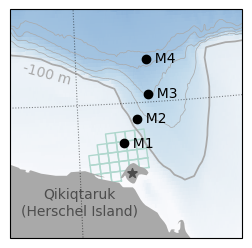

In [108]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-141.1, -137.4)
lat_range = (69.25, 70.5)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': proj})

# ax.set_boundary(clip_path, transform=proj)
# ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.25],linestyles=['solid'], transform=dsic['proj'])
# ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 5
# norm=norm,
mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                      cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

mesh =  ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['darkgray'], transform=ccrs.PlateCarree())


gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
gl.xlocator = FixedLocator([-160, -150, -140, -130])
gl.ylocator = FixedLocator([70,72,])
gl.bottom_labels = False
gl.right_labels = False
# for lat in [70,72,]:
#     ax.text(-124.5, lat, f"{lat}°N",
#             transform=ccrs.PlateCarree(),
#             ha='left', va='center', clip_on=False, rotation=15)
# for lon in [-160, -150, -140, -130]:
#     ax.text(lon, 68.35, f"{-lon}°W",
#             transform=ccrs.PlateCarree(),
#             ha='center', va='top', clip_on=False, rotation=0)

COLOR = [0.3,0.3,0.3]

for m in moors.keys():
    ax.scatter(moors[m]['lon'], moors[m]['lat'], transform=ccrs.PlateCarree(), c='k', zorder=100)
    ax.text(moors[m]['lon'], moors[m]['lat'], f'  {m}', weight='normal', va='center', transform=ccrs.PlateCarree(), c='k', zorder=100)
    

# ax.text(-150,70., 'Beaufort Shelf', rotation=-21,c=COLOR, transform=ccrs.PlateCarree())
# ax.text(-137,69.75, 'Mackenzie Shelf', rotation=35, c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-153, 72, 'Barrow\nCanyon', rotation=0, ha='center', c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-138, 70.5, 'Mackenzie\nCanyon', rotation=0,ha='center', c=COLOR,transform=ccrs.PlateCarree())

# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())
# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())


ax.text(0.3, 0.1, 'Qikiqtaruk\n(Herschel Island)', weight='normal', rotation=0, ha='center', c=COLOR,transform=ax.transAxes)

ax.scatter(-139.15, 69.595, marker='*', s=50, c=COLOR, zorder=100, transform=ccrs.PlateCarree())


ax.text(0.05, 0.675, '-100 m', c='darkgray', rotation = -15, transform=ax.transAxes)

# ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# plt.scatter(df2.x_pts, df2.y_pts,s=8, 
#             facecolor='None', edgecolor='orange',marker='s',  transform=dsic['proj'], zorder=5)

for xxx, yyy in zip(df2.x_pts, df2.y_pts):

    plt.plot([xxx-6250/2,xxx+6250/2,xxx+6250/2,xxx-6250/2,xxx-6250/2,],
             [yyy-6250/2,yyy-6250/2,yyy+6250/2,yyy+6250/2, yyy-6250/2,], 
             c=[175/255, 215/255, 205/255], lw=1,  transform=dsic['proj'], zorder=1)

#     [255/255, 205/255, 60/255]
    
# [0.9,0.7,0.9]
fig.savefig('../figures/overview/bath_map_extrazoom_withfootprint.png', dpi=400, bbox_inches='tight', pad_inches=0)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)


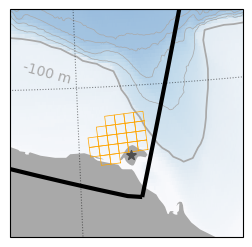

In [98]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-141.1, -137.4)
lat_range = (69.15, 70.4)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': proj})

# ax.set_boundary(clip_path, transform=proj)
# ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.25],linestyles=['solid'], transform=dsic['proj'])
# ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 5
# norm=norm,
mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                      cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

mesh =  ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['darkgray'], transform=ccrs.PlateCarree())


gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
gl.xlocator = FixedLocator([-160, -150, -140, -130])
gl.ylocator = FixedLocator([70,72,])
gl.bottom_labels = False
gl.right_labels = False

COLOR = [0.3,0.3,0.3]


ax.scatter(-139.15, 69.595, marker='*', s=50, c=COLOR, zorder=100, transform=ccrs.PlateCarree())


ax.text(0.05, 0.675, '-100 m', c='darkgray', rotation = -15, transform=ax.transAxes)

ax.add_geometries([reg_poly], lw=3, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
# plt.scatter(df2.x_pts, df2.y_pts,s=5, c='r', transform=dsic['proj'], zorder=1000)
for xxx, yyy in zip(df2.x_pts, df2.y_pts):

    plt.plot([xxx-6250/2,xxx+6250/2,xxx+6250/2,xxx-6250/2,xxx-6250/2,],
             [yyy-6250/2,yyy-6250/2,yyy+6250/2,yyy+6250/2, yyy-6250/2,], 
             c='orange', lw=0.5,  transform=dsic['proj'], zorder=5)
    
# ax.plot(lon_circ, lat_circ, transform=ccrs.PlateCarree(), 
#             c=[0.3,0.3,0.3], lw=1, zorder=98, ls='dashed')

In [73]:
lon_circ = []
lat_circ = []
for bear in np.arange(-180,181,5):

#     endlon, endlat, backaz = g.fwd(-139.15, 69.595, bear, 25*1000)
    endlon, endlat, backaz = g.fwd(-139.2, 69.63, bear, 25*1000)
    lon_circ.append(endlon)
    lat_circ.append(endlat)
    


In [76]:
df2 = pd.read_csv('../data/start_points_v7.6.nc')

In [ ]:
# ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
#            cmap=cmap, norm=norm, transform=dsic['proj'])


# Optional: Gridlines




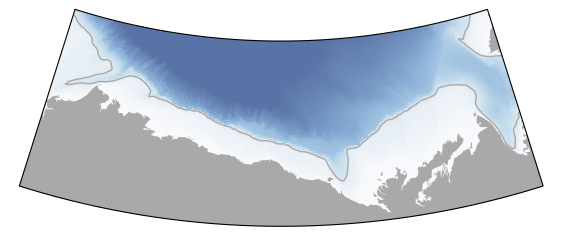

In [17]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-160, -125)
lat_range = (68.5, 73)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': proj})

ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
# ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 20
# norm=norm,
# mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
           cmap=cmap, norm=norm, transform=dsic['proj'])


In [254]:
dss

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    time                  datetime64[ns] 2024-01-14
Data variables: (12/40)
    N                     float64 ...
    extent                float64 ...
    max_length            float64 ...
    max_length_direction  float64 ...
    com_length            float64 ...
    com_direction         float64 ...
    ...                    ...
    land_extent           float64 ...
    ice_extent            float64 ...
    ocean_extent          float64 ...
    other_polynya_extent  float64 ...
    polynya_extent        float64 ...
    miss_flag             bool ...

In [261]:
dss = xr.open_dataset('../data/polynya_size/daily_polynya_2024_sic10_v7.4_radius25km.nc')
dss = dss.sel(time=datetime(2024,1,14))

xx_poly = np.array([float(XX) for XX in dss.poly_interior_xx.values.item().split('_')[1:]])
yy_poly = np.array([float(YY) for YY in dss.poly_interior_yy.values.item().split('_')[1:]])

xx_edge = np.array([float(XX) for XX in dss.ice_edge_xx.values.item().split('_')[1:]])
yy_edge = np.array([float(YY) for YY in dss.ice_edge_yy.values.item().split('_')[1:]])


poly_points = np.full(dsic['xx'].shape, 0.0)

for xx, yy  in zip(xx_poly, yy_poly):
    
    dist = (dsic['xx'] - xx)**2 + (dsic['yy'] - yy)**2
    
    poly_points[np.where(dist == 0)] =1.0
    
for xx, yy  in zip(xx_edge, yy_edge):
    
    dist = (dsic['xx'] - xx)**2 + (dsic['yy'] - yy)**2
    
    poly_points[np.where(dist == 0)] =0.5

Text(0.1, 0.8, 'Mackenzie\nCanyon')

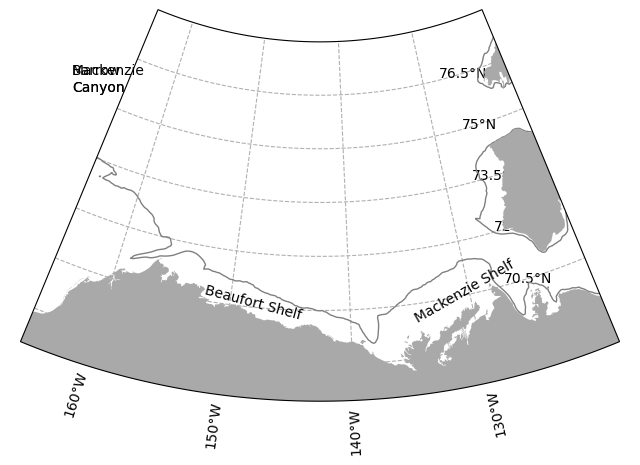

In [211]:


# Optional: Gridlines
gl = ax.gridlines(crs=pc, draw_labels=True, linestyle='--')
gl.top_labels = False



# ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'], cmap=cmap, norm=norm,  transform=dsic['proj'])
ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])

geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
# geomap.coast(ax, )


ax.text(-152,70, 'Beaufort Shelf', rotation=-15, transform=ccrs.PlateCarree())
ax.text(-135,70, 'Mackenzie Shelf', rotation=30, transform=ccrs.PlateCarree())
ax.text(0.1,0.8, 'Barrow\nCanyon', rotation=0, transform=ax.transAxes)
ax.text(0.1,0.8, 'Mackenzie\nCanyon', rotation=0, transform=ax.transAxes)

# ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
#